<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE2] - Building and training an AE denoiser model
<!-- DESC --> Episode 1 : Construction of a denoising autoencoder and training of it with a noisy MNIST dataset.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a denoizing **autoencoder** neurals network (AE)
 - First overview or example of Keras procedural syntax

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard
 
## Data Terminology :
- `clean_train`, `clean_test` for noiseless images 
- `noisy_train`, `noisy_test` for noisy images
- `denoised_test` for denoised images at the output of the model

## Step 1 - Init python stuff
### 1.1 - Init

In [1]:
import numpy as np
from skimage import io
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys
from importlib import reload
import h5py

from modules.MNIST          import MNIST
from modules.ImagesCallback import ImagesCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/AE2'
datasets_dir = pwk.init('AE2', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.20
Notebook id          : AE2
Run time             : Sunday 14 March 2021, 22:24:54
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/AE2
Update keras cache   : False
Save figs            : True
Path figs            : ./run/AE2/figs


### 1.2 - Parameters
`prepared_dataset` : Filename of the prepared dataset (Need 400 Mo, but can be in ./data)  
`dataset_seed` : Random seed for shuffling dataset  
`scale` : % of the dataset to use (1. for 100%)  
`latent_dim` : Dimension of the latent space  
`train_prop` : Percentage for train (the rest being for the test)
`batch_size` : Batch size  
`epochs` : Nb of epochs for training


In [2]:
prepared_dataset = './data/mnist-noisy.h5'
dataset_seed     = 123

scale            = .1

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 30

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('prepared_dataset', 'dataset_seed', 'scale', 'latent_dim')
pwk.override('train_prop', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1.0


**\*\* Overrided parameters : \*\***

epochs               : 30


## Step 2 - Retrieve dataset
With our MNIST class, in one call, we can reload, rescale, shuffle and split our previously saved dataset :-)

In [4]:
clean_train,clean_test, noisy_train,noisy_test, _,_ = MNIST.reload_prepared_dataset(scale      = scale, 
                                                                                    train_prop = train_prop,
                                                                                    seed       = dataset_seed,
                                                                                    shuffle    = True,
                                                                                    filename=prepared_dataset )

Loaded.
rescaled (1.0).
Seeded (123)


Shuffled.
splited (0.8).


clean_train shape is :  (56000, 28, 28, 1)
clean_test  shape is :  (14000, 28, 28, 1)
noisy_train shape is :  (56000, 28, 28, 1)
noisy_test  shape is :  (14000, 28, 28, 1)
class_train shape is :  (56000,)
class_test  shape is :  (14000,)
Blake2b digest is    :  849ddca256f308db28ef


## Step 3 - Build models

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
# encoder.summary()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()

#### AE


In [7]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name="ae")

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [8]:
# ---- Callback : Images
#
pwk.mkdir( run_dir + '/images')
filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=clean_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
#
pwk.mkdir( run_dir + '/models')
filename = run_dir + '/models/best_model.h5'
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

# ---- Callback tensorboard
#
logdir = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)

# callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images, callback_bestmodel]

In [9]:
pwk.chrono_start()

history = ae.fit(noisy_train, clean_train,
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = 1,
                 validation_data = (noisy_test, clean_test),
                 callbacks       = callbacks_list  )

pwk.chrono_show()

Epoch 1/30


  1/438 [..............................] - ETA: 23:49 - loss: 0.6931

 14/438 [..............................] - ETA: 1s - loss: 0.6624   

 27/438 [>.............................] - ETA: 1s - loss: 0.5965

 40/438 [=>............................] - ETA: 1s - loss: 0.5449

 53/438 [==>...........................] - ETA: 1s - loss: 0.5072

 67/438 [===>..........................] - ETA: 1s - loss: 0.4772

 81/438 [====>.........................] - ETA: 1s - loss: 0.4544

 95/438 [=====>........................] - ETA: 1s - loss: 0.4366

110/438 [======>.......................] - ETA: 1s - loss: 0.4211

125/438 [=======>......................] - ETA: 1s - loss: 0.4085

140/438 [========>.....................] - ETA: 1s - loss: 0.3979

154/438 [=========>....................] - ETA: 1s - loss: 0.3895

169/438 [==========>...................] - ETA: 1s - loss: 0.3818

183/438 [===========>..................] - ETA: 0s - loss: 0.3754

198/438 [============>.................] - ETA: 0s - loss: 0.3694

213/438 [=============>................] - ETA: 0s - loss: 0.3641

228/438 [==============>...............] - ETA: 0s - loss: 0.3593

243/438 [===============>..............] - ETA: 0s - loss: 0.3550

258/438 [================>.............] - ETA: 0s - loss: 0.3511

273/438 [=================>............] - ETA: 0s - loss: 0.3475

287/438 [==================>...........] - ETA: 0s - loss: 0.3444

301/438 [===================>..........] - ETA: 0s - loss: 0.3416

315/438 [====================>.........] - ETA: 0s - loss: 0.3390

330/438 [=====================>........] - ETA: 0s - loss: 0.3363

344/438 [======================>.......] - ETA: 0s - loss: 0.3340

359/438 [=======================>......] - ETA: 0s - loss: 0.3316

374/438 [========================>.....] - ETA: 0s - loss: 0.3294

388/438 [=========================>....] - ETA: 0s - loss: 0.3274

403/438 [==========================>...] - ETA: 0s - loss: 0.3253

418/438 [===========================>..] - ETA: 0s - loss: 0.3233

432/438 [============================>.] - ETA: 0s - loss: 0.3216

438/438 [==============================] - ETA: 0s - loss: 0.3208

438/438 [==============================] - 6s 7ms/step - loss: 0.3207 - val_loss: 0.2085


Epoch 2/30
  1/438 [..............................] - ETA: 1s - loss: 0.2124

 14/438 [..............................] - ETA: 1s - loss: 0.2071

 28/438 [>.............................] - ETA: 1s - loss: 0.2061

 42/438 [=>............................] - ETA: 1s - loss: 0.2056

 57/438 [==>...........................] - ETA: 1s - loss: 0.2052

 71/438 [===>..........................] - ETA: 1s - loss: 0.2050

 86/438 [====>.........................] - ETA: 1s - loss: 0.2046

100/438 [=====>........................] - ETA: 1s - loss: 0.2042

114/438 [======>.......................] - ETA: 1s - loss: 0.2038

128/438 [=======>......................] - ETA: 1s - loss: 0.2034

142/438 [========>.....................] - ETA: 1s - loss: 0.2030

156/438 [=========>....................] - ETA: 1s - loss: 0.2026

170/438 [==========>...................] - ETA: 0s - loss: 0.2022

184/438 [===========>..................] - ETA: 0s - loss: 0.2018

199/438 [============>.................] - ETA: 0s - loss: 0.2014

214/438 [=============>................] - ETA: 0s - loss: 0.2010

228/438 [==============>...............] - ETA: 0s - loss: 0.2006

243/438 [===============>..............] - ETA: 0s - loss: 0.2002

258/438 [================>.............] - ETA: 0s - loss: 0.1998

273/438 [=================>............] - ETA: 0s - loss: 0.1994

287/438 [==================>...........] - ETA: 0s - loss: 0.1990

300/438 [===================>..........] - ETA: 0s - loss: 0.1987

314/438 [====================>.........] - ETA: 0s - loss: 0.1983

327/438 [=====================>........] - ETA: 0s - loss: 0.1980

340/438 [======================>.......] - ETA: 0s - loss: 0.1977

355/438 [=======================>......] - ETA: 0s - loss: 0.1973

369/438 [========================>.....] - ETA: 0s - loss: 0.1970

383/438 [=========================>....] - ETA: 0s - loss: 0.1967

398/438 [==========================>...] - ETA: 0s - loss: 0.1963

412/438 [===========================>..] - ETA: 0s - loss: 0.1960

425/438 [============================>.] - ETA: 0s - loss: 0.1957

438/438 [==============================] - 2s 4ms/step - loss: 0.1955 - val_loss: 0.1729


Epoch 3/30
  1/438 [..............................] - ETA: 1s - loss: 0.1682

 15/438 [>.............................] - ETA: 1s - loss: 0.1745

 29/438 [>.............................] - ETA: 1s - loss: 0.1738

 43/438 [=>............................] - ETA: 1s - loss: 0.1734

 58/438 [==>...........................] - ETA: 1s - loss: 0.1732

 73/438 [====>.........................] - ETA: 1s - loss: 0.1730

 88/438 [=====>........................] - ETA: 1s - loss: 0.1729

103/438 [======>.......................] - ETA: 1s - loss: 0.1727

118/438 [=======>......................] - ETA: 1s - loss: 0.1726

132/438 [========>.....................] - ETA: 1s - loss: 0.1725

147/438 [=========>....................] - ETA: 1s - loss: 0.1724

162/438 [==========>...................] - ETA: 0s - loss: 0.1723

177/438 [===========>..................] - ETA: 0s - loss: 0.1722

191/438 [============>.................] - ETA: 0s - loss: 0.1721

205/438 [=============>................] - ETA: 0s - loss: 0.1721

219/438 [==============>...............] - ETA: 0s - loss: 0.1720

233/438 [==============>...............] - ETA: 0s - loss: 0.1719

248/438 [===============>..............] - ETA: 0s - loss: 0.1719

262/438 [================>.............] - ETA: 0s - loss: 0.1718

276/438 [=================>............] - ETA: 0s - loss: 0.1717

291/438 [==================>...........] - ETA: 0s - loss: 0.1716

305/438 [===================>..........] - ETA: 0s - loss: 0.1716

319/438 [====================>.........] - ETA: 0s - loss: 0.1715

333/438 [=====================>........] - ETA: 0s - loss: 0.1714

347/438 [======================>.......] - ETA: 0s - loss: 0.1714

360/438 [=======================>......] - ETA: 0s - loss: 0.1713

374/438 [========================>.....] - ETA: 0s - loss: 0.1712

389/438 [=========================>....] - ETA: 0s - loss: 0.1712

404/438 [==========================>...] - ETA: 0s - loss: 0.1711

419/438 [===========================>..] - ETA: 0s - loss: 0.1710

433/438 [============================>.] - ETA: 0s - loss: 0.1709

438/438 [==============================] - 2s 4ms/step - loss: 0.1709 - val_loss: 0.1647


Epoch 4/30
  1/438 [..............................] - ETA: 1s - loss: 0.1670

 14/438 [..............................] - ETA: 1s - loss: 0.1651

 27/438 [>.............................] - ETA: 1s - loss: 0.1649

 40/438 [=>............................] - ETA: 1s - loss: 0.1646

 54/438 [==>...........................] - ETA: 1s - loss: 0.1644

 69/438 [===>..........................] - ETA: 1s - loss: 0.1644

 84/438 [====>.........................] - ETA: 1s - loss: 0.1643

 99/438 [=====>........................] - ETA: 1s - loss: 0.1642

114/438 [======>.......................] - ETA: 1s - loss: 0.1642

129/438 [=======>......................] - ETA: 1s - loss: 0.1641

143/438 [========>.....................] - ETA: 1s - loss: 0.1641

156/438 [=========>....................] - ETA: 1s - loss: 0.1640

169/438 [==========>...................] - ETA: 0s - loss: 0.1640

182/438 [===========>..................] - ETA: 0s - loss: 0.1640

196/438 [============>.................] - ETA: 0s - loss: 0.1640

210/438 [=============>................] - ETA: 0s - loss: 0.1640

224/438 [==============>...............] - ETA: 0s - loss: 0.1639

238/438 [===============>..............] - ETA: 0s - loss: 0.1639

252/438 [================>.............] - ETA: 0s - loss: 0.1639

266/438 [=================>............] - ETA: 0s - loss: 0.1639

280/438 [==================>...........] - ETA: 0s - loss: 0.1638

293/438 [===================>..........] - ETA: 0s - loss: 0.1638

308/438 [====================>.........] - ETA: 0s - loss: 0.1638

323/438 [=====================>........] - ETA: 0s - loss: 0.1637

337/438 [======================>.......] - ETA: 0s - loss: 0.1637

351/438 [=======================>......] - ETA: 0s - loss: 0.1637

365/438 [========================>.....] - ETA: 0s - loss: 0.1636

379/438 [========================>.....] - ETA: 0s - loss: 0.1636

394/438 [=========================>....] - ETA: 0s - loss: 0.1636

408/438 [==========================>...] - ETA: 0s - loss: 0.1635

422/438 [===========================>..] - ETA: 0s - loss: 0.1635

436/438 [============================>.] - ETA: 0s - loss: 0.1635

438/438 [==============================] - 2s 4ms/step - loss: 0.1634 - val_loss: 0.1602


Epoch 5/30
  1/438 [..............................] - ETA: 1s - loss: 0.1648

 15/438 [>.............................] - ETA: 1s - loss: 0.1608

 29/438 [>.............................] - ETA: 1s - loss: 0.1601

 43/438 [=>............................] - ETA: 1s - loss: 0.1597

 56/438 [==>...........................] - ETA: 1s - loss: 0.1595

 69/438 [===>..........................] - ETA: 1s - loss: 0.1594

 82/438 [====>.........................] - ETA: 1s - loss: 0.1593

 96/438 [=====>........................] - ETA: 1s - loss: 0.1592

111/438 [======>.......................] - ETA: 1s - loss: 0.1592

126/438 [=======>......................] - ETA: 1s - loss: 0.1591

140/438 [========>.....................] - ETA: 1s - loss: 0.1590

155/438 [=========>....................] - ETA: 1s - loss: 0.1590

170/438 [==========>...................] - ETA: 0s - loss: 0.1589

184/438 [===========>..................] - ETA: 0s - loss: 0.1589

197/438 [============>.................] - ETA: 0s - loss: 0.1589

210/438 [=============>................] - ETA: 0s - loss: 0.1588

225/438 [==============>...............] - ETA: 0s - loss: 0.1588

240/438 [===============>..............] - ETA: 0s - loss: 0.1587

254/438 [================>.............] - ETA: 0s - loss: 0.1587

269/438 [=================>............] - ETA: 0s - loss: 0.1586

284/438 [==================>...........] - ETA: 0s - loss: 0.1586

299/438 [===================>..........] - ETA: 0s - loss: 0.1586

314/438 [====================>.........] - ETA: 0s - loss: 0.1585

328/438 [=====================>........] - ETA: 0s - loss: 0.1585

342/438 [======================>.......] - ETA: 0s - loss: 0.1585

356/438 [=======================>......] - ETA: 0s - loss: 0.1585

371/438 [========================>.....] - ETA: 0s - loss: 0.1585

385/438 [=========================>....] - ETA: 0s - loss: 0.1584

400/438 [==========================>...] - ETA: 0s - loss: 0.1584

414/438 [===========================>..] - ETA: 0s - loss: 0.1584

429/438 [============================>.] - ETA: 0s - loss: 0.1584

438/438 [==============================] - 2s 4ms/step - loss: 0.1584 - val_loss: 0.1570


Epoch 6/30
  1/438 [..............................] - ETA: 1s - loss: 0.1596

 15/438 [>.............................] - ETA: 1s - loss: 0.1566

 29/438 [>.............................] - ETA: 1s - loss: 0.1563

 42/438 [=>............................] - ETA: 1s - loss: 0.1564

 55/438 [==>...........................] - ETA: 1s - loss: 0.1564

 70/438 [===>..........................] - ETA: 1s - loss: 0.1562

 84/438 [====>.........................] - ETA: 1s - loss: 0.1561

 99/438 [=====>........................] - ETA: 1s - loss: 0.1560

114/438 [======>.......................] - ETA: 1s - loss: 0.1560

129/438 [=======>......................] - ETA: 1s - loss: 0.1559

144/438 [========>.....................] - ETA: 1s - loss: 0.1558

158/438 [=========>....................] - ETA: 1s - loss: 0.1558

173/438 [==========>...................] - ETA: 0s - loss: 0.1557

188/438 [===========>..................] - ETA: 0s - loss: 0.1557

203/438 [============>.................] - ETA: 0s - loss: 0.1557

218/438 [=============>................] - ETA: 0s - loss: 0.1556

233/438 [==============>...............] - ETA: 0s - loss: 0.1556

247/438 [===============>..............] - ETA: 0s - loss: 0.1556

262/438 [================>.............] - ETA: 0s - loss: 0.1555

277/438 [=================>............] - ETA: 0s - loss: 0.1555

292/438 [===================>..........] - ETA: 0s - loss: 0.1555

307/438 [====================>.........] - ETA: 0s - loss: 0.1554

321/438 [====================>.........] - ETA: 0s - loss: 0.1554

335/438 [=====================>........] - ETA: 0s - loss: 0.1554

350/438 [======================>.......] - ETA: 0s - loss: 0.1554

364/438 [=======================>......] - ETA: 0s - loss: 0.1554

379/438 [========================>.....] - ETA: 0s - loss: 0.1553

394/438 [=========================>....] - ETA: 0s - loss: 0.1553

409/438 [===========================>..] - ETA: 0s - loss: 0.1553

424/438 [============================>.] - ETA: 0s - loss: 0.1553

438/438 [==============================] - ETA: 0s - loss: 0.1553

438/438 [==============================] - 2s 4ms/step - loss: 0.1553 - val_loss: 0.1550


Epoch 7/30
  1/438 [..............................] - ETA: 1s - loss: 0.1466

 15/438 [>.............................] - ETA: 1s - loss: 0.1519

 29/438 [>.............................] - ETA: 1s - loss: 0.1527

 42/438 [=>............................] - ETA: 1s - loss: 0.1531

 55/438 [==>...........................] - ETA: 1s - loss: 0.1532

 70/438 [===>..........................] - ETA: 1s - loss: 0.1533

 85/438 [====>.........................] - ETA: 1s - loss: 0.1533

100/438 [=====>........................] - ETA: 1s - loss: 0.1533

115/438 [======>.......................] - ETA: 1s - loss: 0.1533

130/438 [=======>......................] - ETA: 1s - loss: 0.1532

145/438 [========>.....................] - ETA: 1s - loss: 0.1532

160/438 [=========>....................] - ETA: 1s - loss: 0.1531

175/438 [==========>...................] - ETA: 0s - loss: 0.1531

189/438 [===========>..................] - ETA: 0s - loss: 0.1531

204/438 [============>.................] - ETA: 0s - loss: 0.1531

219/438 [==============>...............] - ETA: 0s - loss: 0.1531

234/438 [===============>..............] - ETA: 0s - loss: 0.1531

249/438 [================>.............] - ETA: 0s - loss: 0.1531

264/438 [=================>............] - ETA: 0s - loss: 0.1531

279/438 [==================>...........] - ETA: 0s - loss: 0.1531

294/438 [===================>..........] - ETA: 0s - loss: 0.1531

309/438 [====================>.........] - ETA: 0s - loss: 0.1530

323/438 [=====================>........] - ETA: 0s - loss: 0.1530

338/438 [======================>.......] - ETA: 0s - loss: 0.1530

353/438 [=======================>......] - ETA: 0s - loss: 0.1530

368/438 [========================>.....] - ETA: 0s - loss: 0.1530

383/438 [=========================>....] - ETA: 0s - loss: 0.1530

397/438 [==========================>...] - ETA: 0s - loss: 0.1530

411/438 [===========================>..] - ETA: 0s - loss: 0.1530

425/438 [============================>.] - ETA: 0s - loss: 0.1530

438/438 [==============================] - ETA: 0s - loss: 0.1530

438/438 [==============================] - 2s 4ms/step - loss: 0.1530 - val_loss: 0.1545


Epoch 8/30
  1/438 [..............................] - ETA: 1s - loss: 0.1542

 15/438 [>.............................] - ETA: 1s - loss: 0.1526

 29/438 [>.............................] - ETA: 1s - loss: 0.1521

 43/438 [=>............................] - ETA: 1s - loss: 0.1519

 57/438 [==>...........................] - ETA: 1s - loss: 0.1516

 71/438 [===>..........................] - ETA: 1s - loss: 0.1514

 85/438 [====>.........................] - ETA: 1s - loss: 0.1513

 99/438 [=====>........................] - ETA: 1s - loss: 0.1513

113/438 [======>.......................] - ETA: 1s - loss: 0.1513

127/438 [=======>......................] - ETA: 1s - loss: 0.1512

142/438 [========>.....................] - ETA: 1s - loss: 0.1512

155/438 [=========>....................] - ETA: 1s - loss: 0.1512

169/438 [==========>...................] - ETA: 0s - loss: 0.1512

183/438 [===========>..................] - ETA: 0s - loss: 0.1512

197/438 [============>.................] - ETA: 0s - loss: 0.1512

212/438 [=============>................] - ETA: 0s - loss: 0.1512

227/438 [==============>...............] - ETA: 0s - loss: 0.1512

242/438 [===============>..............] - ETA: 0s - loss: 0.1512

257/438 [================>.............] - ETA: 0s - loss: 0.1512

272/438 [=================>............] - ETA: 0s - loss: 0.1512

286/438 [==================>...........] - ETA: 0s - loss: 0.1512

300/438 [===================>..........] - ETA: 0s - loss: 0.1512

314/438 [====================>.........] - ETA: 0s - loss: 0.1512

329/438 [=====================>........] - ETA: 0s - loss: 0.1512

343/438 [======================>.......] - ETA: 0s - loss: 0.1512

357/438 [=======================>......] - ETA: 0s - loss: 0.1512

371/438 [========================>.....] - ETA: 0s - loss: 0.1512

385/438 [=========================>....] - ETA: 0s - loss: 0.1513

399/438 [==========================>...] - ETA: 0s - loss: 0.1513

413/438 [===========================>..] - ETA: 0s - loss: 0.1513

427/438 [============================>.] - ETA: 0s - loss: 0.1513

438/438 [==============================] - 2s 4ms/step - loss: 0.1513 - val_loss: 0.1522


Epoch 9/30
  1/438 [..............................] - ETA: 1s - loss: 0.1484

 15/438 [>.............................] - ETA: 1s - loss: 0.1480

 29/438 [>.............................] - ETA: 1s - loss: 0.1482

 43/438 [=>............................] - ETA: 1s - loss: 0.1484

 57/438 [==>...........................] - ETA: 1s - loss: 0.1485

 72/438 [===>..........................] - ETA: 1s - loss: 0.1486

 87/438 [====>.........................] - ETA: 1s - loss: 0.1487

102/438 [=====>........................] - ETA: 1s - loss: 0.1488

117/438 [=======>......................] - ETA: 1s - loss: 0.1488

132/438 [========>.....................] - ETA: 1s - loss: 0.1489

147/438 [=========>....................] - ETA: 1s - loss: 0.1490

162/438 [==========>...................] - ETA: 0s - loss: 0.1490

177/438 [===========>..................] - ETA: 0s - loss: 0.1491

192/438 [============>.................] - ETA: 0s - loss: 0.1491

207/438 [=============>................] - ETA: 0s - loss: 0.1492

222/438 [==============>...............] - ETA: 0s - loss: 0.1492

237/438 [===============>..............] - ETA: 0s - loss: 0.1493

252/438 [================>.............] - ETA: 0s - loss: 0.1493

267/438 [=================>............] - ETA: 0s - loss: 0.1494

281/438 [==================>...........] - ETA: 0s - loss: 0.1494

296/438 [===================>..........] - ETA: 0s - loss: 0.1494

309/438 [====================>.........] - ETA: 0s - loss: 0.1495

322/438 [=====================>........] - ETA: 0s - loss: 0.1495

337/438 [======================>.......] - ETA: 0s - loss: 0.1495

352/438 [=======================>......] - ETA: 0s - loss: 0.1495

367/438 [========================>.....] - ETA: 0s - loss: 0.1495

382/438 [=========================>....] - ETA: 0s - loss: 0.1496

397/438 [==========================>...] - ETA: 0s - loss: 0.1496

412/438 [===========================>..] - ETA: 0s - loss: 0.1496

427/438 [============================>.] - ETA: 0s - loss: 0.1496

438/438 [==============================] - 2s 4ms/step - loss: 0.1496 - val_loss: 0.1517


Epoch 10/30
  1/438 [..............................] - ETA: 1s - loss: 0.1386

 15/438 [>.............................] - ETA: 1s - loss: 0.1471

 29/438 [>.............................] - ETA: 1s - loss: 0.1475

 43/438 [=>............................] - ETA: 1s - loss: 0.1478

 58/438 [==>...........................] - ETA: 1s - loss: 0.1479

 72/438 [===>..........................] - ETA: 1s - loss: 0.1480

 86/438 [====>.........................] - ETA: 1s - loss: 0.1481

101/438 [=====>........................] - ETA: 1s - loss: 0.1482

116/438 [======>.......................] - ETA: 1s - loss: 0.1482

131/438 [=======>......................] - ETA: 1s - loss: 0.1483

146/438 [=========>....................] - ETA: 1s - loss: 0.1483

161/438 [==========>...................] - ETA: 0s - loss: 0.1483

175/438 [==========>...................] - ETA: 0s - loss: 0.1483

190/438 [============>.................] - ETA: 0s - loss: 0.1484

205/438 [=============>................] - ETA: 0s - loss: 0.1484

220/438 [==============>...............] - ETA: 0s - loss: 0.1484

235/438 [===============>..............] - ETA: 0s - loss: 0.1485

249/438 [================>.............] - ETA: 0s - loss: 0.1485

263/438 [=================>............] - ETA: 0s - loss: 0.1485

277/438 [=================>............] - ETA: 0s - loss: 0.1485

291/438 [==================>...........] - ETA: 0s - loss: 0.1486

304/438 [===================>..........] - ETA: 0s - loss: 0.1486

318/438 [====================>.........] - ETA: 0s - loss: 0.1486

333/438 [=====================>........] - ETA: 0s - loss: 0.1486

348/438 [======================>.......] - ETA: 0s - loss: 0.1486

363/438 [=======================>......] - ETA: 0s - loss: 0.1486

377/438 [========================>.....] - ETA: 0s - loss: 0.1486

391/438 [=========================>....] - ETA: 0s - loss: 0.1486

406/438 [==========================>...] - ETA: 0s - loss: 0.1487

421/438 [===========================>..] - ETA: 0s - loss: 0.1487

436/438 [============================>.] - ETA: 0s - loss: 0.1487

438/438 [==============================] - 2s 4ms/step - loss: 0.1487 - val_loss: 0.1513


Epoch 11/30
  1/438 [..............................] - ETA: 1s - loss: 0.1518

 15/438 [>.............................] - ETA: 1s - loss: 0.1487

 29/438 [>.............................] - ETA: 1s - loss: 0.1483

 43/438 [=>............................] - ETA: 1s - loss: 0.1485

 57/438 [==>...........................] - ETA: 1s - loss: 0.1485

 71/438 [===>..........................] - ETA: 1s - loss: 0.1484

 86/438 [====>.........................] - ETA: 1s - loss: 0.1483

100/438 [=====>........................] - ETA: 1s - loss: 0.1482

114/438 [======>.......................] - ETA: 1s - loss: 0.1482

129/438 [=======>......................] - ETA: 1s - loss: 0.1481

143/438 [========>.....................] - ETA: 1s - loss: 0.1480

157/438 [=========>....................] - ETA: 1s - loss: 0.1480

171/438 [==========>...................] - ETA: 0s - loss: 0.1480

186/438 [===========>..................] - ETA: 0s - loss: 0.1480

201/438 [============>.................] - ETA: 0s - loss: 0.1480

216/438 [=============>................] - ETA: 0s - loss: 0.1480

231/438 [==============>...............] - ETA: 0s - loss: 0.1479

245/438 [===============>..............] - ETA: 0s - loss: 0.1479

260/438 [================>.............] - ETA: 0s - loss: 0.1480

274/438 [=================>............] - ETA: 0s - loss: 0.1480

288/438 [==================>...........] - ETA: 0s - loss: 0.1480

303/438 [===================>..........] - ETA: 0s - loss: 0.1480

318/438 [====================>.........] - ETA: 0s - loss: 0.1480

332/438 [=====================>........] - ETA: 0s - loss: 0.1480

346/438 [======================>.......] - ETA: 0s - loss: 0.1480

360/438 [=======================>......] - ETA: 0s - loss: 0.1480

374/438 [========================>.....] - ETA: 0s - loss: 0.1480

387/438 [=========================>....] - ETA: 0s - loss: 0.1480

400/438 [==========================>...] - ETA: 0s - loss: 0.1480

414/438 [===========================>..] - ETA: 0s - loss: 0.1480

429/438 [============================>.] - ETA: 0s - loss: 0.1480

438/438 [==============================] - 2s 4ms/step - loss: 0.1480 - val_loss: 0.1504


Epoch 12/30
  1/438 [..............................] - ETA: 1s - loss: 0.1556

 15/438 [>.............................] - ETA: 1s - loss: 0.1502

 29/438 [>.............................] - ETA: 1s - loss: 0.1494

 44/438 [==>...........................] - ETA: 1s - loss: 0.1489

 59/438 [===>..........................] - ETA: 1s - loss: 0.1486

 74/438 [====>.........................] - ETA: 1s - loss: 0.1484

 89/438 [=====>........................] - ETA: 1s - loss: 0.1482

103/438 [======>.......................] - ETA: 1s - loss: 0.1480

117/438 [=======>......................] - ETA: 1s - loss: 0.1480

130/438 [=======>......................] - ETA: 1s - loss: 0.1479

143/438 [========>.....................] - ETA: 1s - loss: 0.1478

156/438 [=========>....................] - ETA: 1s - loss: 0.1478

169/438 [==========>...................] - ETA: 1s - loss: 0.1478

182/438 [===========>..................] - ETA: 0s - loss: 0.1477

195/438 [============>.................] - ETA: 0s - loss: 0.1477

210/438 [=============>................] - ETA: 0s - loss: 0.1477

225/438 [==============>...............] - ETA: 0s - loss: 0.1477

240/438 [===============>..............] - ETA: 0s - loss: 0.1476

254/438 [================>.............] - ETA: 0s - loss: 0.1476

267/438 [=================>............] - ETA: 0s - loss: 0.1476

281/438 [==================>...........] - ETA: 0s - loss: 0.1476

296/438 [===================>..........] - ETA: 0s - loss: 0.1476

311/438 [====================>.........] - ETA: 0s - loss: 0.1476

325/438 [=====================>........] - ETA: 0s - loss: 0.1476

339/438 [======================>.......] - ETA: 0s - loss: 0.1476

353/438 [=======================>......] - ETA: 0s - loss: 0.1475

368/438 [========================>.....] - ETA: 0s - loss: 0.1475

383/438 [=========================>....] - ETA: 0s - loss: 0.1475

398/438 [==========================>...] - ETA: 0s - loss: 0.1475

413/438 [===========================>..] - ETA: 0s - loss: 0.1475

428/438 [============================>.] - ETA: 0s - loss: 0.1475

438/438 [==============================] - 2s 4ms/step - loss: 0.1475 - val_loss: 0.1512


Epoch 13/30
  1/438 [..............................] - ETA: 1s - loss: 0.1480

 15/438 [>.............................] - ETA: 1s - loss: 0.1461

 30/438 [=>............................] - ETA: 1s - loss: 0.1460

 45/438 [==>...........................] - ETA: 1s - loss: 0.1460

 60/438 [===>..........................] - ETA: 1s - loss: 0.1460

 75/438 [====>.........................] - ETA: 1s - loss: 0.1459

 89/438 [=====>........................] - ETA: 1s - loss: 0.1459

104/438 [======>.......................] - ETA: 1s - loss: 0.1460

119/438 [=======>......................] - ETA: 1s - loss: 0.1460

133/438 [========>.....................] - ETA: 1s - loss: 0.1460

148/438 [=========>....................] - ETA: 1s - loss: 0.1461

163/438 [==========>...................] - ETA: 0s - loss: 0.1461

178/438 [===========>..................] - ETA: 0s - loss: 0.1461

193/438 [============>.................] - ETA: 0s - loss: 0.1462

208/438 [=============>................] - ETA: 0s - loss: 0.1462

223/438 [==============>...............] - ETA: 0s - loss: 0.1462

237/438 [===============>..............] - ETA: 0s - loss: 0.1463

251/438 [================>.............] - ETA: 0s - loss: 0.1463

266/438 [=================>............] - ETA: 0s - loss: 0.1463

281/438 [==================>...........] - ETA: 0s - loss: 0.1463

296/438 [===================>..........] - ETA: 0s - loss: 0.1463

311/438 [====================>.........] - ETA: 0s - loss: 0.1463

326/438 [=====================>........] - ETA: 0s - loss: 0.1463

341/438 [======================>.......] - ETA: 0s - loss: 0.1464

356/438 [=======================>......] - ETA: 0s - loss: 0.1464

371/438 [========================>.....] - ETA: 0s - loss: 0.1464

386/438 [=========================>....] - ETA: 0s - loss: 0.1464

399/438 [==========================>...] - ETA: 0s - loss: 0.1464

412/438 [===========================>..] - ETA: 0s - loss: 0.1464

425/438 [============================>.] - ETA: 0s - loss: 0.1464

438/438 [==============================] - ETA: 0s - loss: 0.1464

438/438 [==============================] - 2s 4ms/step - loss: 0.1464 - val_loss: 0.1501


Epoch 14/30
  1/438 [..............................] - ETA: 2s - loss: 0.1469

 14/438 [..............................] - ETA: 1s - loss: 0.1442

 27/438 [>.............................] - ETA: 1s - loss: 0.1447

 40/438 [=>............................] - ETA: 1s - loss: 0.1450

 53/438 [==>...........................] - ETA: 1s - loss: 0.1451

 66/438 [===>..........................] - ETA: 1s - loss: 0.1452

 79/438 [====>.........................] - ETA: 1s - loss: 0.1453

 92/438 [=====>........................] - ETA: 1s - loss: 0.1454

107/438 [======>.......................] - ETA: 1s - loss: 0.1454

121/438 [=======>......................] - ETA: 1s - loss: 0.1455

136/438 [========>.....................] - ETA: 1s - loss: 0.1455

151/438 [=========>....................] - ETA: 1s - loss: 0.1455

164/438 [==========>...................] - ETA: 1s - loss: 0.1455

179/438 [===========>..................] - ETA: 0s - loss: 0.1455

194/438 [============>.................] - ETA: 0s - loss: 0.1455

209/438 [=============>................] - ETA: 0s - loss: 0.1455

224/438 [==============>...............] - ETA: 0s - loss: 0.1455

238/438 [===============>..............] - ETA: 0s - loss: 0.1456

253/438 [================>.............] - ETA: 0s - loss: 0.1456

268/438 [=================>............] - ETA: 0s - loss: 0.1456

283/438 [==================>...........] - ETA: 0s - loss: 0.1456

298/438 [===================>..........] - ETA: 0s - loss: 0.1456

313/438 [====================>.........] - ETA: 0s - loss: 0.1456

328/438 [=====================>........] - ETA: 0s - loss: 0.1456

343/438 [======================>.......] - ETA: 0s - loss: 0.1456

358/438 [=======================>......] - ETA: 0s - loss: 0.1457

373/438 [========================>.....] - ETA: 0s - loss: 0.1457

388/438 [=========================>....] - ETA: 0s - loss: 0.1457

403/438 [==========================>...] - ETA: 0s - loss: 0.1457

418/438 [===========================>..] - ETA: 0s - loss: 0.1457

433/438 [============================>.] - ETA: 0s - loss: 0.1457

438/438 [==============================] - 2s 4ms/step - loss: 0.1457 - val_loss: 0.1502


Epoch 15/30
  1/438 [..............................] - ETA: 1s - loss: 0.1424

 15/438 [>.............................] - ETA: 1s - loss: 0.1448

 29/438 [>.............................] - ETA: 1s - loss: 0.1454

 43/438 [=>............................] - ETA: 1s - loss: 0.1454

 57/438 [==>...........................] - ETA: 1s - loss: 0.1453

 71/438 [===>..........................] - ETA: 1s - loss: 0.1453

 85/438 [====>.........................] - ETA: 1s - loss: 0.1452

 99/438 [=====>........................] - ETA: 1s - loss: 0.1452

113/438 [======>.......................] - ETA: 1s - loss: 0.1452

127/438 [=======>......................] - ETA: 1s - loss: 0.1452

141/438 [========>.....................] - ETA: 1s - loss: 0.1452

155/438 [=========>....................] - ETA: 1s - loss: 0.1452

169/438 [==========>...................] - ETA: 0s - loss: 0.1452

183/438 [===========>..................] - ETA: 0s - loss: 0.1451

197/438 [============>.................] - ETA: 0s - loss: 0.1451

211/438 [=============>................] - ETA: 0s - loss: 0.1451

225/438 [==============>...............] - ETA: 0s - loss: 0.1451

239/438 [===============>..............] - ETA: 0s - loss: 0.1451

253/438 [================>.............] - ETA: 0s - loss: 0.1451

267/438 [=================>............] - ETA: 0s - loss: 0.1451

281/438 [==================>...........] - ETA: 0s - loss: 0.1451

295/438 [===================>..........] - ETA: 0s - loss: 0.1451

309/438 [====================>.........] - ETA: 0s - loss: 0.1452

323/438 [=====================>........] - ETA: 0s - loss: 0.1452

337/438 [======================>.......] - ETA: 0s - loss: 0.1452

351/438 [=======================>......] - ETA: 0s - loss: 0.1452

365/438 [========================>.....] - ETA: 0s - loss: 0.1452

379/438 [========================>.....] - ETA: 0s - loss: 0.1452

393/438 [=========================>....] - ETA: 0s - loss: 0.1452

408/438 [==========================>...] - ETA: 0s - loss: 0.1452

422/438 [===========================>..] - ETA: 0s - loss: 0.1452

437/438 [============================>.] - ETA: 0s - loss: 0.1452

438/438 [==============================] - 2s 4ms/step - loss: 0.1452 - val_loss: 0.1496


Epoch 16/30
  1/438 [..............................] - ETA: 1s - loss: 0.1555

 14/438 [..............................] - ETA: 1s - loss: 0.1464

 28/438 [>.............................] - ETA: 1s - loss: 0.1455

 42/438 [=>............................] - ETA: 1s - loss: 0.1450

 56/438 [==>...........................] - ETA: 1s - loss: 0.1449

 71/438 [===>..........................] - ETA: 1s - loss: 0.1447

 86/438 [====>.........................] - ETA: 1s - loss: 0.1447

101/438 [=====>........................] - ETA: 1s - loss: 0.1446

116/438 [======>.......................] - ETA: 1s - loss: 0.1446

131/438 [=======>......................] - ETA: 1s - loss: 0.1446

146/438 [=========>....................] - ETA: 1s - loss: 0.1445

161/438 [==========>...................] - ETA: 0s - loss: 0.1445

176/438 [===========>..................] - ETA: 0s - loss: 0.1445

191/438 [============>.................] - ETA: 0s - loss: 0.1445

206/438 [=============>................] - ETA: 0s - loss: 0.1445

221/438 [==============>...............] - ETA: 0s - loss: 0.1445

235/438 [===============>..............] - ETA: 0s - loss: 0.1445

250/438 [================>.............] - ETA: 0s - loss: 0.1446

264/438 [=================>............] - ETA: 0s - loss: 0.1446

279/438 [==================>...........] - ETA: 0s - loss: 0.1446

294/438 [===================>..........] - ETA: 0s - loss: 0.1446

308/438 [====================>.........] - ETA: 0s - loss: 0.1446

323/438 [=====================>........] - ETA: 0s - loss: 0.1446

338/438 [======================>.......] - ETA: 0s - loss: 0.1446

353/438 [=======================>......] - ETA: 0s - loss: 0.1447

367/438 [========================>.....] - ETA: 0s - loss: 0.1447

382/438 [=========================>....] - ETA: 0s - loss: 0.1447

396/438 [==========================>...] - ETA: 0s - loss: 0.1447

409/438 [===========================>..] - ETA: 0s - loss: 0.1447

422/438 [===========================>..] - ETA: 0s - loss: 0.1447

435/438 [============================>.] - ETA: 0s - loss: 0.1447

438/438 [==============================] - 2s 4ms/step - loss: 0.1447 - val_loss: 0.1494


Epoch 17/30
  1/438 [..............................] - ETA: 1s - loss: 0.1410

 15/438 [>.............................] - ETA: 1s - loss: 0.1432

 29/438 [>.............................] - ETA: 1s - loss: 0.1440

 42/438 [=>............................] - ETA: 1s - loss: 0.1443

 56/438 [==>...........................] - ETA: 1s - loss: 0.1444

 70/438 [===>..........................] - ETA: 1s - loss: 0.1444

 84/438 [====>.........................] - ETA: 1s - loss: 0.1443

 98/438 [=====>........................] - ETA: 1s - loss: 0.1443

112/438 [======>.......................] - ETA: 1s - loss: 0.1443

126/438 [=======>......................] - ETA: 1s - loss: 0.1443

139/438 [========>.....................] - ETA: 1s - loss: 0.1443

152/438 [=========>....................] - ETA: 1s - loss: 0.1442

165/438 [==========>...................] - ETA: 1s - loss: 0.1442

178/438 [===========>..................] - ETA: 0s - loss: 0.1442

191/438 [============>.................] - ETA: 0s - loss: 0.1442

204/438 [============>.................] - ETA: 0s - loss: 0.1442

217/438 [=============>................] - ETA: 0s - loss: 0.1441

230/438 [==============>...............] - ETA: 0s - loss: 0.1441

244/438 [===============>..............] - ETA: 0s - loss: 0.1441

257/438 [================>.............] - ETA: 0s - loss: 0.1441

270/438 [=================>............] - ETA: 0s - loss: 0.1441

283/438 [==================>...........] - ETA: 0s - loss: 0.1441

296/438 [===================>..........] - ETA: 0s - loss: 0.1441

309/438 [====================>.........] - ETA: 0s - loss: 0.1441

322/438 [=====================>........] - ETA: 0s - loss: 0.1441

336/438 [======================>.......] - ETA: 0s - loss: 0.1441

350/438 [======================>.......] - ETA: 0s - loss: 0.1441

365/438 [========================>.....] - ETA: 0s - loss: 0.1441

380/438 [=========================>....] - ETA: 0s - loss: 0.1442

395/438 [==========================>...] - ETA: 0s - loss: 0.1442

410/438 [===========================>..] - ETA: 0s - loss: 0.1442

425/438 [============================>.] - ETA: 0s - loss: 0.1442

438/438 [==============================] - 2s 4ms/step - loss: 0.1442 - val_loss: 0.1496


Epoch 18/30
  1/438 [..............................] - ETA: 1s - loss: 0.1393

 15/438 [>.............................] - ETA: 1s - loss: 0.1410

 29/438 [>.............................] - ETA: 1s - loss: 0.1418

 43/438 [=>............................] - ETA: 1s - loss: 0.1422

 57/438 [==>...........................] - ETA: 1s - loss: 0.1424

 71/438 [===>..........................] - ETA: 1s - loss: 0.1426

 86/438 [====>.........................] - ETA: 1s - loss: 0.1427

101/438 [=====>........................] - ETA: 1s - loss: 0.1428

116/438 [======>.......................] - ETA: 1s - loss: 0.1428

131/438 [=======>......................] - ETA: 1s - loss: 0.1429

145/438 [========>.....................] - ETA: 1s - loss: 0.1429

158/438 [=========>....................] - ETA: 1s - loss: 0.1429

171/438 [==========>...................] - ETA: 0s - loss: 0.1429

184/438 [===========>..................] - ETA: 0s - loss: 0.1429

199/438 [============>.................] - ETA: 0s - loss: 0.1430

213/438 [=============>................] - ETA: 0s - loss: 0.1430

228/438 [==============>...............] - ETA: 0s - loss: 0.1430

243/438 [===============>..............] - ETA: 0s - loss: 0.1430

258/438 [================>.............] - ETA: 0s - loss: 0.1431

273/438 [=================>............] - ETA: 0s - loss: 0.1431

288/438 [==================>...........] - ETA: 0s - loss: 0.1431

302/438 [===================>..........] - ETA: 0s - loss: 0.1432

317/438 [====================>.........] - ETA: 0s - loss: 0.1432

331/438 [=====================>........] - ETA: 0s - loss: 0.1432

345/438 [======================>.......] - ETA: 0s - loss: 0.1433

359/438 [=======================>......] - ETA: 0s - loss: 0.1433

374/438 [========================>.....] - ETA: 0s - loss: 0.1433

389/438 [=========================>....] - ETA: 0s - loss: 0.1433

404/438 [==========================>...] - ETA: 0s - loss: 0.1434

419/438 [===========================>..] - ETA: 0s - loss: 0.1434

433/438 [============================>.] - ETA: 0s - loss: 0.1434

438/438 [==============================] - 2s 4ms/step - loss: 0.1434 - val_loss: 0.1496


Epoch 19/30
  1/438 [..............................] - ETA: 1s - loss: 0.1494

 14/438 [..............................] - ETA: 1s - loss: 0.1444

 28/438 [>.............................] - ETA: 1s - loss: 0.1432

 42/438 [=>............................] - ETA: 1s - loss: 0.1429

 57/438 [==>...........................] - ETA: 1s - loss: 0.1428

 71/438 [===>..........................] - ETA: 1s - loss: 0.1428

 86/438 [====>.........................] - ETA: 1s - loss: 0.1428

100/438 [=====>........................] - ETA: 1s - loss: 0.1429

115/438 [======>.......................] - ETA: 1s - loss: 0.1430

130/438 [=======>......................] - ETA: 1s - loss: 0.1430

144/438 [========>.....................] - ETA: 1s - loss: 0.1431

159/438 [=========>....................] - ETA: 1s - loss: 0.1431

174/438 [==========>...................] - ETA: 0s - loss: 0.1432

189/438 [===========>..................] - ETA: 0s - loss: 0.1432

204/438 [============>.................] - ETA: 0s - loss: 0.1432

218/438 [=============>................] - ETA: 0s - loss: 0.1433

233/438 [==============>...............] - ETA: 0s - loss: 0.1433

247/438 [===============>..............] - ETA: 0s - loss: 0.1433

260/438 [================>.............] - ETA: 0s - loss: 0.1433

274/438 [=================>............] - ETA: 0s - loss: 0.1434

289/438 [==================>...........] - ETA: 0s - loss: 0.1434

304/438 [===================>..........] - ETA: 0s - loss: 0.1434

318/438 [====================>.........] - ETA: 0s - loss: 0.1434

332/438 [=====================>........] - ETA: 0s - loss: 0.1434

346/438 [======================>.......] - ETA: 0s - loss: 0.1434

360/438 [=======================>......] - ETA: 0s - loss: 0.1435

374/438 [========================>.....] - ETA: 0s - loss: 0.1435

388/438 [=========================>....] - ETA: 0s - loss: 0.1435

402/438 [==========================>...] - ETA: 0s - loss: 0.1435

416/438 [===========================>..] - ETA: 0s - loss: 0.1435

429/438 [============================>.] - ETA: 0s - loss: 0.1435

438/438 [==============================] - 2s 4ms/step - loss: 0.1435 - val_loss: 0.1496


Epoch 20/30
  1/438 [..............................] - ETA: 1s - loss: 0.1459

 15/438 [>.............................] - ETA: 1s - loss: 0.1439

 29/438 [>.............................] - ETA: 1s - loss: 0.1434

 43/438 [=>............................] - ETA: 1s - loss: 0.1432

 57/438 [==>...........................] - ETA: 1s - loss: 0.1431

 71/438 [===>..........................] - ETA: 1s - loss: 0.1431

 85/438 [====>.........................] - ETA: 1s - loss: 0.1431

 99/438 [=====>........................] - ETA: 1s - loss: 0.1431

113/438 [======>.......................] - ETA: 1s - loss: 0.1431

127/438 [=======>......................] - ETA: 1s - loss: 0.1431

141/438 [========>.....................] - ETA: 1s - loss: 0.1431

155/438 [=========>....................] - ETA: 1s - loss: 0.1432

169/438 [==========>...................] - ETA: 0s - loss: 0.1432

183/438 [===========>..................] - ETA: 0s - loss: 0.1432

197/438 [============>.................] - ETA: 0s - loss: 0.1432

211/438 [=============>................] - ETA: 0s - loss: 0.1432

225/438 [==============>...............] - ETA: 0s - loss: 0.1432

239/438 [===============>..............] - ETA: 0s - loss: 0.1432

253/438 [================>.............] - ETA: 0s - loss: 0.1432

267/438 [=================>............] - ETA: 0s - loss: 0.1432

281/438 [==================>...........] - ETA: 0s - loss: 0.1432

295/438 [===================>..........] - ETA: 0s - loss: 0.1432

309/438 [====================>.........] - ETA: 0s - loss: 0.1432

323/438 [=====================>........] - ETA: 0s - loss: 0.1432

337/438 [======================>.......] - ETA: 0s - loss: 0.1432

351/438 [=======================>......] - ETA: 0s - loss: 0.1433

365/438 [========================>.....] - ETA: 0s - loss: 0.1433

379/438 [========================>.....] - ETA: 0s - loss: 0.1433

394/438 [=========================>....] - ETA: 0s - loss: 0.1433

409/438 [===========================>..] - ETA: 0s - loss: 0.1433

424/438 [============================>.] - ETA: 0s - loss: 0.1433

438/438 [==============================] - 2s 4ms/step - loss: 0.1433 - val_loss: 0.1491


Epoch 21/30
  1/438 [..............................] - ETA: 1s - loss: 0.1419

 14/438 [..............................] - ETA: 1s - loss: 0.1407

 27/438 [>.............................] - ETA: 1s - loss: 0.1413

 41/438 [=>............................] - ETA: 1s - loss: 0.1414

 56/438 [==>...........................] - ETA: 1s - loss: 0.1415

 71/438 [===>..........................] - ETA: 1s - loss: 0.1415

 86/438 [====>.........................] - ETA: 1s - loss: 0.1415

101/438 [=====>........................] - ETA: 1s - loss: 0.1416

116/438 [======>.......................] - ETA: 1s - loss: 0.1417

130/438 [=======>......................] - ETA: 1s - loss: 0.1417

143/438 [========>.....................] - ETA: 1s - loss: 0.1418

156/438 [=========>....................] - ETA: 1s - loss: 0.1418

170/438 [==========>...................] - ETA: 0s - loss: 0.1419

185/438 [===========>..................] - ETA: 0s - loss: 0.1419

200/438 [============>.................] - ETA: 0s - loss: 0.1420

215/438 [=============>................] - ETA: 0s - loss: 0.1420

229/438 [==============>...............] - ETA: 0s - loss: 0.1420

244/438 [===============>..............] - ETA: 0s - loss: 0.1421

258/438 [================>.............] - ETA: 0s - loss: 0.1421

273/438 [=================>............] - ETA: 0s - loss: 0.1422

287/438 [==================>...........] - ETA: 0s - loss: 0.1422

302/438 [===================>..........] - ETA: 0s - loss: 0.1422

317/438 [====================>.........] - ETA: 0s - loss: 0.1422

332/438 [=====================>........] - ETA: 0s - loss: 0.1423

347/438 [======================>.......] - ETA: 0s - loss: 0.1423

362/438 [=======================>......] - ETA: 0s - loss: 0.1423

375/438 [========================>.....] - ETA: 0s - loss: 0.1423

388/438 [=========================>....] - ETA: 0s - loss: 0.1424

402/438 [==========================>...] - ETA: 0s - loss: 0.1424

415/438 [===========================>..] - ETA: 0s - loss: 0.1424

429/438 [============================>.] - ETA: 0s - loss: 0.1424

438/438 [==============================] - 2s 4ms/step - loss: 0.1424 - val_loss: 0.1492


Epoch 22/30
  1/438 [..............................] - ETA: 1s - loss: 0.1369

 15/438 [>.............................] - ETA: 1s - loss: 0.1397

 29/438 [>.............................] - ETA: 1s - loss: 0.1402

 44/438 [==>...........................] - ETA: 1s - loss: 0.1405

 59/438 [===>..........................] - ETA: 1s - loss: 0.1407

 73/438 [====>.........................] - ETA: 1s - loss: 0.1408

 88/438 [=====>........................] - ETA: 1s - loss: 0.1409

102/438 [=====>........................] - ETA: 1s - loss: 0.1410

117/438 [=======>......................] - ETA: 1s - loss: 0.1411

132/438 [========>.....................] - ETA: 1s - loss: 0.1412

147/438 [=========>....................] - ETA: 1s - loss: 0.1413

162/438 [==========>...................] - ETA: 0s - loss: 0.1414

177/438 [===========>..................] - ETA: 0s - loss: 0.1414

192/438 [============>.................] - ETA: 0s - loss: 0.1415

207/438 [=============>................] - ETA: 0s - loss: 0.1415

222/438 [==============>...............] - ETA: 0s - loss: 0.1415

237/438 [===============>..............] - ETA: 0s - loss: 0.1416

252/438 [================>.............] - ETA: 0s - loss: 0.1416

267/438 [=================>............] - ETA: 0s - loss: 0.1416

282/438 [==================>...........] - ETA: 0s - loss: 0.1417

297/438 [===================>..........] - ETA: 0s - loss: 0.1417

312/438 [====================>.........] - ETA: 0s - loss: 0.1417

326/438 [=====================>........] - ETA: 0s - loss: 0.1418

340/438 [======================>.......] - ETA: 0s - loss: 0.1418

355/438 [=======================>......] - ETA: 0s - loss: 0.1418

370/438 [========================>.....] - ETA: 0s - loss: 0.1418

385/438 [=========================>....] - ETA: 0s - loss: 0.1419

400/438 [==========================>...] - ETA: 0s - loss: 0.1419

414/438 [===========================>..] - ETA: 0s - loss: 0.1419

429/438 [============================>.] - ETA: 0s - loss: 0.1419

438/438 [==============================] - 2s 4ms/step - loss: 0.1420 - val_loss: 0.1495


Epoch 23/30
  1/438 [..............................] - ETA: 1s - loss: 0.1435

 15/438 [>.............................] - ETA: 1s - loss: 0.1429

 29/438 [>.............................] - ETA: 1s - loss: 0.1423

 44/438 [==>...........................] - ETA: 1s - loss: 0.1420

 59/438 [===>..........................] - ETA: 1s - loss: 0.1420

 74/438 [====>.........................] - ETA: 1s - loss: 0.1420

 89/438 [=====>........................] - ETA: 1s - loss: 0.1420

104/438 [======>.......................] - ETA: 1s - loss: 0.1420

119/438 [=======>......................] - ETA: 1s - loss: 0.1420

134/438 [========>.....................] - ETA: 1s - loss: 0.1420

148/438 [=========>....................] - ETA: 1s - loss: 0.1420

162/438 [==========>...................] - ETA: 0s - loss: 0.1420

176/438 [===========>..................] - ETA: 0s - loss: 0.1420

191/438 [============>.................] - ETA: 0s - loss: 0.1420

206/438 [=============>................] - ETA: 0s - loss: 0.1420

220/438 [==============>...............] - ETA: 0s - loss: 0.1420

234/438 [===============>..............] - ETA: 0s - loss: 0.1420

248/438 [===============>..............] - ETA: 0s - loss: 0.1420

262/438 [================>.............] - ETA: 0s - loss: 0.1420

277/438 [=================>............] - ETA: 0s - loss: 0.1421

291/438 [==================>...........] - ETA: 0s - loss: 0.1421

305/438 [===================>..........] - ETA: 0s - loss: 0.1421

319/438 [====================>.........] - ETA: 0s - loss: 0.1421

333/438 [=====================>........] - ETA: 0s - loss: 0.1421

347/438 [======================>.......] - ETA: 0s - loss: 0.1421

361/438 [=======================>......] - ETA: 0s - loss: 0.1421

374/438 [========================>.....] - ETA: 0s - loss: 0.1421

387/438 [=========================>....] - ETA: 0s - loss: 0.1421

402/438 [==========================>...] - ETA: 0s - loss: 0.1421

417/438 [===========================>..] - ETA: 0s - loss: 0.1421

432/438 [============================>.] - ETA: 0s - loss: 0.1422

438/438 [==============================] - 2s 4ms/step - loss: 0.1422 - val_loss: 0.1494


Epoch 24/30
  1/438 [..............................] - ETA: 1s - loss: 0.1361

 15/438 [>.............................] - ETA: 1s - loss: 0.1403

 30/438 [=>............................] - ETA: 1s - loss: 0.1405

 45/438 [==>...........................] - ETA: 1s - loss: 0.1410

 59/438 [===>..........................] - ETA: 1s - loss: 0.1413

 73/438 [====>.........................] - ETA: 1s - loss: 0.1415

 88/438 [=====>........................] - ETA: 1s - loss: 0.1416

103/438 [======>.......................] - ETA: 1s - loss: 0.1417

118/438 [=======>......................] - ETA: 1s - loss: 0.1417

133/438 [========>.....................] - ETA: 1s - loss: 0.1418

148/438 [=========>....................] - ETA: 1s - loss: 0.1419

163/438 [==========>...................] - ETA: 0s - loss: 0.1419

178/438 [===========>..................] - ETA: 0s - loss: 0.1419

193/438 [============>.................] - ETA: 0s - loss: 0.1419

208/438 [=============>................] - ETA: 0s - loss: 0.1419

223/438 [==============>...............] - ETA: 0s - loss: 0.1419

236/438 [===============>..............] - ETA: 0s - loss: 0.1419

250/438 [================>.............] - ETA: 0s - loss: 0.1419

264/438 [=================>............] - ETA: 0s - loss: 0.1419

278/438 [==================>...........] - ETA: 0s - loss: 0.1419

291/438 [==================>...........] - ETA: 0s - loss: 0.1419

305/438 [===================>..........] - ETA: 0s - loss: 0.1419

320/438 [====================>.........] - ETA: 0s - loss: 0.1419

335/438 [=====================>........] - ETA: 0s - loss: 0.1419

350/438 [======================>.......] - ETA: 0s - loss: 0.1419

365/438 [========================>.....] - ETA: 0s - loss: 0.1419

379/438 [========================>.....] - ETA: 0s - loss: 0.1419

394/438 [=========================>....] - ETA: 0s - loss: 0.1419

409/438 [===========================>..] - ETA: 0s - loss: 0.1419

424/438 [============================>.] - ETA: 0s - loss: 0.1419

437/438 [============================>.] - ETA: 0s - loss: 0.1420

438/438 [==============================] - 2s 4ms/step - loss: 0.1420 - val_loss: 0.1494


Epoch 25/30
  1/438 [..............................] - ETA: 1s - loss: 0.1414

 14/438 [..............................] - ETA: 1s - loss: 0.1397

 27/438 [>.............................] - ETA: 1s - loss: 0.1401

 41/438 [=>............................] - ETA: 1s - loss: 0.1404

 56/438 [==>...........................] - ETA: 1s - loss: 0.1406

 71/438 [===>..........................] - ETA: 1s - loss: 0.1408

 86/438 [====>.........................] - ETA: 1s - loss: 0.1409

101/438 [=====>........................] - ETA: 1s - loss: 0.1410

116/438 [======>.......................] - ETA: 1s - loss: 0.1410

131/438 [=======>......................] - ETA: 1s - loss: 0.1411

146/438 [=========>....................] - ETA: 1s - loss: 0.1411

161/438 [==========>...................] - ETA: 1s - loss: 0.1411

176/438 [===========>..................] - ETA: 0s - loss: 0.1412

191/438 [============>.................] - ETA: 0s - loss: 0.1412

206/438 [=============>................] - ETA: 0s - loss: 0.1412

220/438 [==============>...............] - ETA: 0s - loss: 0.1413

235/438 [===============>..............] - ETA: 0s - loss: 0.1413

250/438 [================>.............] - ETA: 0s - loss: 0.1413

265/438 [=================>............] - ETA: 0s - loss: 0.1414

280/438 [==================>...........] - ETA: 0s - loss: 0.1414

295/438 [===================>..........] - ETA: 0s - loss: 0.1414

310/438 [====================>.........] - ETA: 0s - loss: 0.1414

325/438 [=====================>........] - ETA: 0s - loss: 0.1414

340/438 [======================>.......] - ETA: 0s - loss: 0.1415

354/438 [=======================>......] - ETA: 0s - loss: 0.1415

368/438 [========================>.....] - ETA: 0s - loss: 0.1415

382/438 [=========================>....] - ETA: 0s - loss: 0.1415

396/438 [==========================>...] - ETA: 0s - loss: 0.1415

410/438 [===========================>..] - ETA: 0s - loss: 0.1415

424/438 [============================>.] - ETA: 0s - loss: 0.1415

437/438 [============================>.] - ETA: 0s - loss: 0.1415

438/438 [==============================] - 2s 4ms/step - loss: 0.1415 - val_loss: 0.1501


Epoch 26/30
  1/438 [..............................] - ETA: 1s - loss: 0.1387

  2/438 [..............................] - ETA: 53s - loss: 0.1402

 16/438 [>.............................] - ETA: 4s - loss: 0.1415 

 30/438 [=>............................] - ETA: 3s - loss: 0.1416

 43/438 [=>............................] - ETA: 2s - loss: 0.1415

 57/438 [==>...........................] - ETA: 2s - loss: 0.1414

 72/438 [===>..........................] - ETA: 1s - loss: 0.1413

 87/438 [====>.........................] - ETA: 1s - loss: 0.1413

102/438 [=====>........................] - ETA: 1s - loss: 0.1412

116/438 [======>.......................] - ETA: 1s - loss: 0.1411

131/438 [=======>......................] - ETA: 1s - loss: 0.1411

146/438 [=========>....................] - ETA: 1s - loss: 0.1411

161/438 [==========>...................] - ETA: 1s - loss: 0.1410

175/438 [==========>...................] - ETA: 1s - loss: 0.1410

190/438 [============>.................] - ETA: 1s - loss: 0.1410

205/438 [=============>................] - ETA: 0s - loss: 0.1410

220/438 [==============>...............] - ETA: 0s - loss: 0.1410

235/438 [===============>..............] - ETA: 0s - loss: 0.1410

250/438 [================>.............] - ETA: 0s - loss: 0.1410

264/438 [=================>............] - ETA: 0s - loss: 0.1410

278/438 [==================>...........] - ETA: 0s - loss: 0.1410

293/438 [===================>..........] - ETA: 0s - loss: 0.1410

307/438 [====================>.........] - ETA: 0s - loss: 0.1410

322/438 [=====================>........] - ETA: 0s - loss: 0.1410

337/438 [======================>.......] - ETA: 0s - loss: 0.1410

352/438 [=======================>......] - ETA: 0s - loss: 0.1410

366/438 [========================>.....] - ETA: 0s - loss: 0.1410

381/438 [=========================>....] - ETA: 0s - loss: 0.1411

396/438 [==========================>...] - ETA: 0s - loss: 0.1411

411/438 [===========================>..] - ETA: 0s - loss: 0.1411

425/438 [============================>.] - ETA: 0s - loss: 0.1411

438/438 [==============================] - 2s 4ms/step - loss: 0.1411 - val_loss: 0.1494


Epoch 27/30
  1/438 [..............................] - ETA: 1s - loss: 0.1378

 15/438 [>.............................] - ETA: 1s - loss: 0.1404

 29/438 [>.............................] - ETA: 1s - loss: 0.1405

 44/438 [==>...........................] - ETA: 1s - loss: 0.1406

 59/438 [===>..........................] - ETA: 1s - loss: 0.1406

 74/438 [====>.........................] - ETA: 1s - loss: 0.1406

 89/438 [=====>........................] - ETA: 1s - loss: 0.1406

104/438 [======>.......................] - ETA: 1s - loss: 0.1406

117/438 [=======>......................] - ETA: 1s - loss: 0.1407

130/438 [=======>......................] - ETA: 1s - loss: 0.1407

143/438 [========>.....................] - ETA: 1s - loss: 0.1407

156/438 [=========>....................] - ETA: 1s - loss: 0.1407

169/438 [==========>...................] - ETA: 1s - loss: 0.1407

182/438 [===========>..................] - ETA: 0s - loss: 0.1408

197/438 [============>.................] - ETA: 0s - loss: 0.1408

212/438 [=============>................] - ETA: 0s - loss: 0.1408

227/438 [==============>...............] - ETA: 0s - loss: 0.1408

242/438 [===============>..............] - ETA: 0s - loss: 0.1408

257/438 [================>.............] - ETA: 0s - loss: 0.1409

271/438 [=================>............] - ETA: 0s - loss: 0.1409

286/438 [==================>...........] - ETA: 0s - loss: 0.1409

301/438 [===================>..........] - ETA: 0s - loss: 0.1409

316/438 [====================>.........] - ETA: 0s - loss: 0.1409

331/438 [=====================>........] - ETA: 0s - loss: 0.1409

346/438 [======================>.......] - ETA: 0s - loss: 0.1410

361/438 [=======================>......] - ETA: 0s - loss: 0.1410

376/438 [========================>.....] - ETA: 0s - loss: 0.1410

391/438 [=========================>....] - ETA: 0s - loss: 0.1410

406/438 [==========================>...] - ETA: 0s - loss: 0.1410

421/438 [===========================>..] - ETA: 0s - loss: 0.1410

435/438 [============================>.] - ETA: 0s - loss: 0.1410

438/438 [==============================] - 2s 4ms/step - loss: 0.1410 - val_loss: 0.1497


Epoch 28/30
  1/438 [..............................] - ETA: 1s - loss: 0.1392

 15/438 [>.............................] - ETA: 1s - loss: 0.1432

 29/438 [>.............................] - ETA: 1s - loss: 0.1424

 44/438 [==>...........................] - ETA: 1s - loss: 0.1419

 59/438 [===>..........................] - ETA: 1s - loss: 0.1416

 74/438 [====>.........................] - ETA: 1s - loss: 0.1414

 89/438 [=====>........................] - ETA: 1s - loss: 0.1413

104/438 [======>.......................] - ETA: 1s - loss: 0.1412

119/438 [=======>......................] - ETA: 1s - loss: 0.1411

134/438 [========>.....................] - ETA: 1s - loss: 0.1410

148/438 [=========>....................] - ETA: 1s - loss: 0.1410

163/438 [==========>...................] - ETA: 0s - loss: 0.1409

178/438 [===========>..................] - ETA: 0s - loss: 0.1409

192/438 [============>.................] - ETA: 0s - loss: 0.1409

207/438 [=============>................] - ETA: 0s - loss: 0.1409

222/438 [==============>...............] - ETA: 0s - loss: 0.1409

237/438 [===============>..............] - ETA: 0s - loss: 0.1409

251/438 [================>.............] - ETA: 0s - loss: 0.1409

266/438 [=================>............] - ETA: 0s - loss: 0.1409

281/438 [==================>...........] - ETA: 0s - loss: 0.1409

295/438 [===================>..........] - ETA: 0s - loss: 0.1409

310/438 [====================>.........] - ETA: 0s - loss: 0.1409

324/438 [=====================>........] - ETA: 0s - loss: 0.1409

339/438 [======================>.......] - ETA: 0s - loss: 0.1409

354/438 [=======================>......] - ETA: 0s - loss: 0.1409

369/438 [========================>.....] - ETA: 0s - loss: 0.1409

384/438 [=========================>....] - ETA: 0s - loss: 0.1409

399/438 [==========================>...] - ETA: 0s - loss: 0.1410

414/438 [===========================>..] - ETA: 0s - loss: 0.1410

428/438 [============================>.] - ETA: 0s - loss: 0.1410

438/438 [==============================] - 2s 4ms/step - loss: 0.1410 - val_loss: 0.1493


Epoch 29/30
  1/438 [..............................] - ETA: 1s - loss: 0.1375

 14/438 [..............................] - ETA: 1s - loss: 0.1420

 29/438 [>.............................] - ETA: 1s - loss: 0.1414

 44/438 [==>...........................] - ETA: 1s - loss: 0.1411

 59/438 [===>..........................] - ETA: 1s - loss: 0.1410

 74/438 [====>.........................] - ETA: 1s - loss: 0.1407

 88/438 [=====>........................] - ETA: 1s - loss: 0.1406

103/438 [======>.......................] - ETA: 1s - loss: 0.1406

118/438 [=======>......................] - ETA: 1s - loss: 0.1405

133/438 [========>.....................] - ETA: 1s - loss: 0.1405

147/438 [=========>....................] - ETA: 1s - loss: 0.1404

162/438 [==========>...................] - ETA: 0s - loss: 0.1404

177/438 [===========>..................] - ETA: 0s - loss: 0.1404

192/438 [============>.................] - ETA: 0s - loss: 0.1404

206/438 [=============>................] - ETA: 0s - loss: 0.1404

220/438 [==============>...............] - ETA: 0s - loss: 0.1404

234/438 [===============>..............] - ETA: 0s - loss: 0.1404

248/438 [===============>..............] - ETA: 0s - loss: 0.1404

263/438 [=================>............] - ETA: 0s - loss: 0.1404

278/438 [==================>...........] - ETA: 0s - loss: 0.1405

293/438 [===================>..........] - ETA: 0s - loss: 0.1405

308/438 [====================>.........] - ETA: 0s - loss: 0.1405

323/438 [=====================>........] - ETA: 0s - loss: 0.1405

338/438 [======================>.......] - ETA: 0s - loss: 0.1405

353/438 [=======================>......] - ETA: 0s - loss: 0.1405

367/438 [========================>.....] - ETA: 0s - loss: 0.1405

381/438 [=========================>....] - ETA: 0s - loss: 0.1405

396/438 [==========================>...] - ETA: 0s - loss: 0.1405

411/438 [===========================>..] - ETA: 0s - loss: 0.1405

425/438 [============================>.] - ETA: 0s - loss: 0.1406

438/438 [==============================] - ETA: 0s - loss: 0.1406

438/438 [==============================] - 2s 4ms/step - loss: 0.1406 - val_loss: 0.1497


Epoch 30/30
  1/438 [..............................] - ETA: 1s - loss: 0.1355

 15/438 [>.............................] - ETA: 1s - loss: 0.1389

 29/438 [>.............................] - ETA: 1s - loss: 0.1391

 44/438 [==>...........................] - ETA: 1s - loss: 0.1394

 59/438 [===>..........................] - ETA: 1s - loss: 0.1395

 74/438 [====>.........................] - ETA: 1s - loss: 0.1396

 89/438 [=====>........................] - ETA: 1s - loss: 0.1396

104/438 [======>.......................] - ETA: 1s - loss: 0.1397

119/438 [=======>......................] - ETA: 1s - loss: 0.1397

134/438 [========>.....................] - ETA: 1s - loss: 0.1397

149/438 [=========>....................] - ETA: 1s - loss: 0.1397

163/438 [==========>...................] - ETA: 0s - loss: 0.1397

177/438 [===========>..................] - ETA: 0s - loss: 0.1398

191/438 [============>.................] - ETA: 0s - loss: 0.1398

205/438 [=============>................] - ETA: 0s - loss: 0.1398

219/438 [==============>...............] - ETA: 0s - loss: 0.1398

233/438 [==============>...............] - ETA: 0s - loss: 0.1398

247/438 [===============>..............] - ETA: 0s - loss: 0.1398

261/438 [================>.............] - ETA: 0s - loss: 0.1398

275/438 [=================>............] - ETA: 0s - loss: 0.1398

289/438 [==================>...........] - ETA: 0s - loss: 0.1399

303/438 [===================>..........] - ETA: 0s - loss: 0.1399

317/438 [====================>.........] - ETA: 0s - loss: 0.1399

332/438 [=====================>........] - ETA: 0s - loss: 0.1399

347/438 [======================>.......] - ETA: 0s - loss: 0.1399

362/438 [=======================>......] - ETA: 0s - loss: 0.1400

377/438 [========================>.....] - ETA: 0s - loss: 0.1400

392/438 [=========================>....] - ETA: 0s - loss: 0.1400

406/438 [==========================>...] - ETA: 0s - loss: 0.1400

421/438 [===========================>..] - ETA: 0s - loss: 0.1400

436/438 [============================>.] - ETA: 0s - loss: 0.1401

438/438 [==============================] - 2s 4ms/step - loss: 0.1401 - val_loss: 0.1495



Duration :  00:01:05 039ms


## Step 5 - History

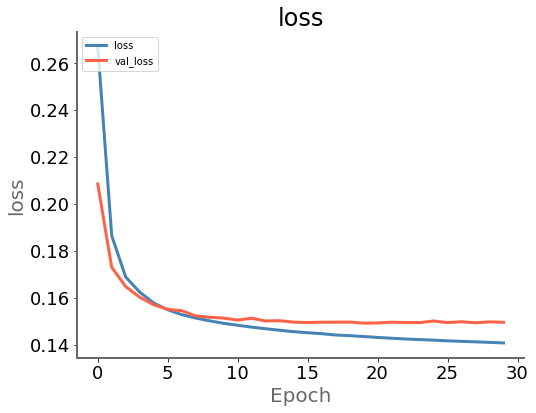

In [10]:
pwk.plot_history(history,  plot={'loss':['loss','val_loss']}, save_as='01-history')

## Step 6 - Denoising progress

<br>**Real images (clean_test) :**

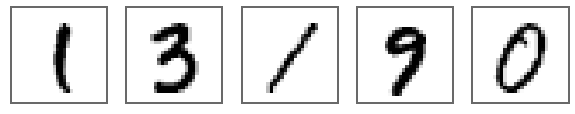

<br>**Noisy images (noisy_test) :**

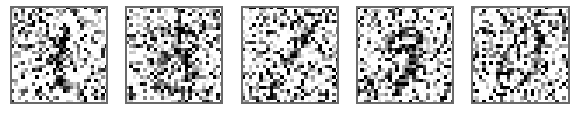

<br>**Evolution during the training period (denoised_test) :**

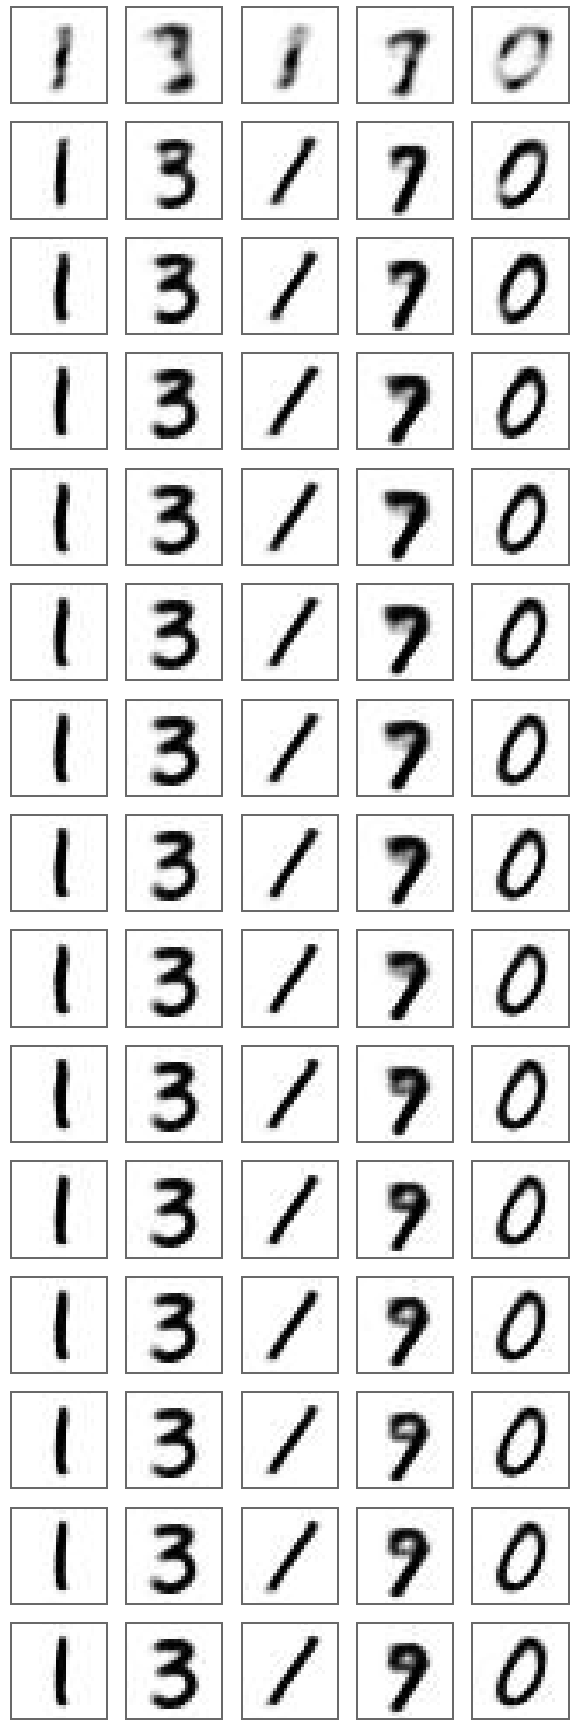

<br>**Noisy images (noisy_test) :**

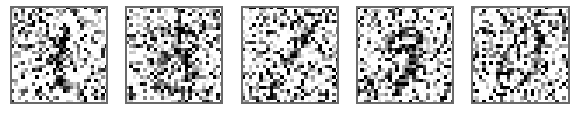

<br>**Real images (clean_test) :**

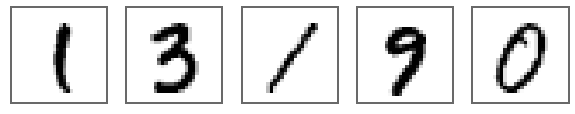

In [11]:
imgs=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)      

pwk.subtitle('Real images (clean_test) :')
pwk.plot_images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='02-original-real')

pwk.subtitle('Noisy images (noisy_test) :')
pwk.plot_images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='03-original-noisy')

pwk.subtitle('Evolution during the training period (denoised_test) :')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, y_padding=0.1, save_as='04-learning')

pwk.subtitle('Noisy images (noisy_test) :')
pwk.plot_images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images (clean_test) :')
pwk.plot_images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


## Step 7 - Evaluation
**Note :** We will use the following data:\
`clean_train`, `clean_test` for noiseless images \
`noisy_train`, `noisy_test` for noisy images\
`denoised_test` for denoised images at the output of the model
 
### 7.1 - Reload our best model

In [12]:
model = keras.models.load_model(f'{run_dir}/models/best_model.h5')

### 7.2 - Let's make a prediction

In [13]:
denoised_test = model.predict(noisy_test)

print('Denoised images   (denoised_test) shape : ',denoised_test.shape)

Denoised images   (denoised_test) shape :  (14000, 28, 28, 1)


### 7.3 - Denoised images 

<br>**Noisy test images (input):**

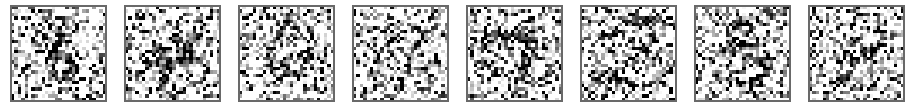

<br>**Denoised images (output):**

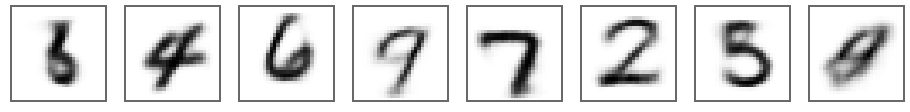

<br>**Real test images :**

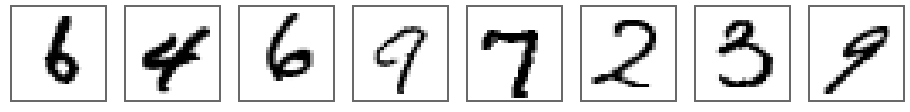

In [14]:
i=random.randint(0,len(denoised_test)-8)
j=i+8

pwk.subtitle('Noisy test images (input):')
pwk.plot_images(noisy_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='05-test-noisy')

pwk.subtitle('Denoised images (output):')
pwk.plot_images(denoised_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='06-test-predict')

pwk.subtitle('Real test images :')
pwk.plot_images(clean_test[i:j], None, indices='all', columns=8, x_size=2,y_size=2, interpolation=None, save_as='07-test-real')

In [15]:
pwk.end()

End time is : Sunday 14 March 2021, 22:26:11
Duration is : 00:01:17 493ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>